In [176]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp,arange
from scipy.optimize import curve_fit
from scipy.fftpack import ifft,irfft, fftfreq
from itertools import combinations
import scipy.optimize as op
from past.builtins import xrange
from scipy.optimize import fsolve
from scipy.interpolate import UnivariateSpline

In [177]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
def FFT(xs,ys, add_zeros='False'):
    
    '''
    It returns the FT of the ys values. 
    '''
    
    dt= xs[1]-xs[0]
    
    if add_zeros=='True':
        
        N_zeros = 1000
        t_tail = np.linspace(xs[-1]+dt, xs[-1]+dt*N_zeros, N_zeros)
        t_head = np.linspace(xs[0]-N_zeros*dt, xs[0]-dt, N_zeros)
        t_final = np.concatenate([t_head, xs, t_tail])
        Ftd_final = np.concatenate([np.zeros(N_zeros), ys, np.zeros(N_zeros)])
        N = len(t_final)
    else:
        N=len(xs)
        t_final=xs
        Ftd_final=ys
        
    # 4. FFT
    ## note: Ftd_final is real, so first half of the FFT series gives usable information
    ##      you can either remove the second half of ifft results, or use a dedicated function ihfft   
    Fw=np.fft.ihfft(Ftd_final)
    ## multiply back what is divided
    Fw *= N
    ## multiply sampling interval to transfer sum to integral
    Fw *= dt
    freq = np.fft.rfftfreq(N,d=dt)
    omega = freq*2.*np.pi
    
    return omega[1:],Fw[1:]



def FT_clas(freq,T,mu, xs, ys):
    
    '''
    semi-calssical analytical contribution, eq. 34 and 39 -- Ulmer's paper 

    '''   
    if mu<0:
        #saddle point
        return 1j*np.exp(1j*freq*T)*np.sqrt(-mu)

    else:
        #min/max point
        return -1*np.exp(1j*freq*T)*np.sqrt(mu)
    

def Fd_w(xs,ys,t_ori,Ft_ori):
    
    '''
    eq. 5.6  
    
    Note that t_final and Ftd_final may contain zeros and the beginning and the end that's why we 
    use xs and ys on the last equation.
    '''
    
    omega,Fw=FFT(xs,ys)    
    Fw = Fw*omega/(2j*np.pi)-Ft_ori[0]*np.exp(1j*omega*t_ori[0])/2/np.pi
    
    return omega,Fw



In [179]:
def fit_Func(t_ori,Ft_orig,funct, lin_type='log'):
    
    '''
    fitting of the smoothed curve
    '''
    dt = 1e-3
      
    if funct=='ftd': 
        
        '''
        Fitting of F_d(t) in  order to have a smoother curve and a constant timestep dt.        
        '''
        
        fitting_order=50
        t_new = np.arange(dt, t_ori[-1], dt)
        #xs = np.linspace(np.min(a), np.max(a), n_sample)
        z = np.polyfit(t_ori, Ft_orig, fitting_order)
        p = np.poly1d(z)
        Ft_new=p(t_new)
        
        return t_new, Ft_new
        
    elif funct=='ftd_ext': 
        
        '''
        Fitting of F_d(t) in  order to extrapolate values at higher times. 
        We can use a linear fitting or a log one.        
        '''
        
        t_max = 100
        #begin_fit=np.where(t_ori>np.max(t_ori)-0.2)[0][0]
        t_cut = 0.6
        tail_mask = t_ori>t_cut
        t_new = np.arange(t_cut,t_max , dt)
    
        
        if lin_type=='lin':
            
            fitting_order=1
            z = np.polyfit(t_ori[tail_mask], Ft_orig[tail_mask], fitting_order)
            p = np.poly1d(z)
            Ft_new=p(t_new)
            
        elif lin_type=='log':
                             
            log_t = np.log(t_ori[tail_mask])
            A = np.vstack([log_t, np.ones_like(log_t)]).T
            m, c = np.linalg.lstsq(A, Ft_orig[tail_mask], rcond=None)[0]
            log_t_new = np.log(t_new)
            Ft_new = m*log_t_new+c
            
        t_final = np.concatenate([t_ori, t_new[t_new>(t_ori[-1]+dt/2)]])
        Ftd_final = np.concatenate([Ft_orig, Ft_new[t_new>(t_ori[-1]+dt/2)]])
    
        return t_final, Ftd_final  
    
    else:
        raise Exception('Unsupported fitting type! using either lin or log!')

In [183]:
def Hanning_smooth(t,Ft):
    
    print('Applying hanning smooth')
    
    #mask=t>2 #when to start using the window function
    mask=t>0.8
    
    signal=Ft[mask]
    window_len=100 #decide the lenght of the window
    s=np.r_[signal[window_len-1:0:-1],signal,signal[-2:-window_len-1:-1]]
    print(len(s))
    w=np.hanning(window_len)
    print(len(w))
    
    y=np.convolve(w/w.sum(),s,mode='valid')
    y=y[int((window_len/2-1)):-int((window_len/2))]
    
    Ft_wind=np.r_[Ft[~mask],y]
    print('Hanning smooth done')
    
    return Ft_wind

In [178]:
muI = np.load('muI.npy')
tauI = np.load('tauI.npy')
Ftd = np.load('Ftd.npy')
Ft_list= np.load('Ft_list.npy')
tau_list= np.load('tau_list.npy')

In [153]:
t_new = np.load('t_new.npy')
Ft_new = np.load('Ft_new.npy')

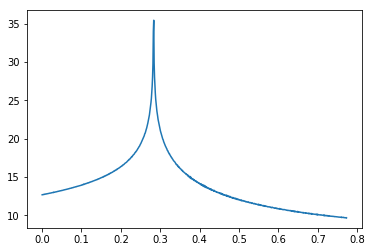

In [180]:
plt.plot(tau_list, Ft_list)

In [181]:
t_smooth, Ftd_smooth=fit_Func(tau_list,Ftd,'ftd')

In [ ]:
#mask=t>2 #when to start using the window function
mask=t>0.8

signal=Ft[mask]
window_len=100 #decide the lenght of the window
s=np.r_[signal[window_len-1:0:-1],signal,signal[-2:-window_len-1:-1]]
print(len(s))
w=np.hanning(window_len)
print(len(w))

y=np.convolve(w/w.sum(),s,mode='valid')
y=y[int((window_len/2-1)):-int((window_len/2))]

Ft_wind=np.r_[Ft[~mask],y]
print('Hanning smooth done')
    

In [184]:
Ftd_smooth=Hanning_smooth(t_smooth,Ftd_smooth)

Applying hanning smooth
0
100


ValueError: v cannot be empty

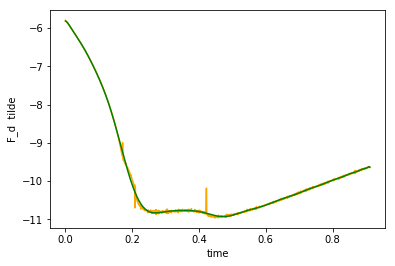

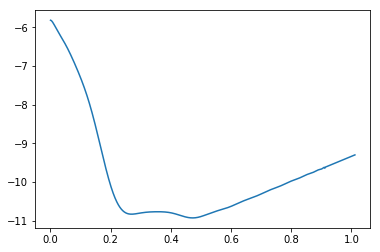

In [48]:
plt.plot(tau_list, Ftd, color='orange')
plt.plot(xs, ys, color='green')
plt.xlabel('time')
plt.ylabel('F_d  tilde')
plt.show()

xs_extended,ys_extended=extend_Fc(xs,ys)
plt.plot(xs_extended,ys_extended)
plt.show()

Using the functions decleared and with the data from the fitted curve we get the diffraction contribution. This explodes in 0. In order to find the error we manually calculate the integral for the FFT.

Using the Euler's formula we divide the contribution of the complex exponential in the FFT. We see that the integral is highly oscillating.

Text(0.5, 1.0, 'Real contribution')

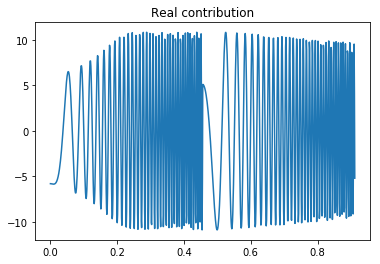

In [50]:
plt.plot(xs,np.cos(omega*xs)*ys)
plt.title('Real contribution')

Text(0.5, 1.0, 'Imaginary contribution')

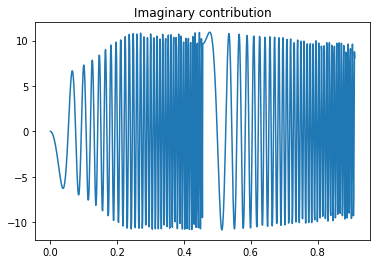

In [51]:
plt.plot(xs,np.sin(omega*xs)*ys)
plt.title('Imaginary contribution')

In [52]:
with open('Re_FT_levin.txt', 'r') as f:
    Re_FT_levin = f.read().splitlines()
    
with open('Im_FT_levin.txt', 'r') as f:
    Im_FT_levin = f.read().splitlines()

omega = fftfreq(len(ys),xs[1]-xs[0])
FT=ifft(ys)

In [53]:
with open('Cos_FT_levin.txt', 'r') as f:
    Cos_FT_levin = f.read().splitlines()
    
with open('Sin_FT_levin.txt', 'r') as f:
    Sin_FT_levin = f.read().splitlines()

Cos_FT_levin=np.asarray([complex(i) for i in Cos_FT_levin])
Sin_FT_levin=np.asarray([1j*complex(i) for i in Sin_FT_levin])

In [54]:
FT_levin=Cos_FT_levin+Sin_FT_levin

Text(0.5, 1.0, 'Python FT')

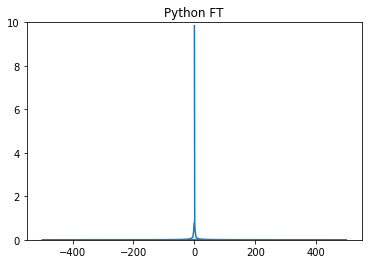

In [55]:
plt.plot(omega, np.abs(FT))
plt.ylim(0,10)
plt.title('Python FT')

Text(0.5, 1.0, 'Mathematica FT')

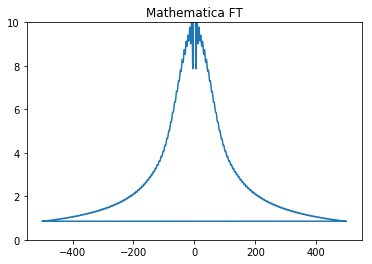

In [56]:
plt.plot(omega,np.abs(FT_levin))
plt.ylim(0,10)
plt.title('Mathematica FT')

In [76]:
c_omega=omega/(2j*np.pi)
first_term= np.exp(1j*omega*xs[-1])*ys[-1]-np.exp(1j*omega*xs[0])*ys[0]
Ff_plot=(first_term[1:] - 1j*omega[1:]*FT[1:])*c_omega[1:]

Text(0.5, 1.0, 'Python F diffraction')

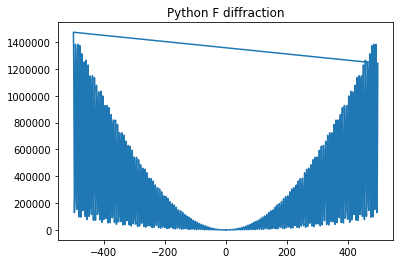

In [77]:
plt.plot(omega[1:],np.abs(Ff_plot)**2, label='F diffraction' )
#plt.ylim(0,2500)
plt.title('Python F diffraction')

Text(0.5, 1.0, 'Mathematica F diffraction')

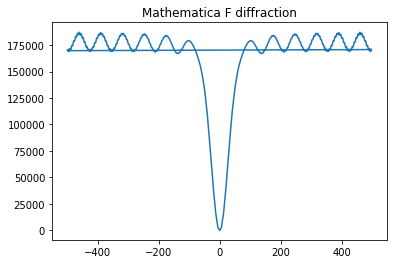

In [91]:
first_term_lev= np.exp(1j*omega*xs[-1])*ys[-1]-np.exp(1j*omega*xs[0])*ys[0]
Ff_plot_lev=(first_term[1:]- 1j*omega[1:]*FT_levin[1:])#*c_omega[1:]
plt.plot(omega[1:],np.abs(Ff_plot_lev)**2, label='F diffraction' )
#plt.ylim(0,2800)
plt.title('Mathematica F diffraction')

In [61]:
np.savetxt('omega.txt', omega, delimiter=' ')

In [45]:
len(xs)

912

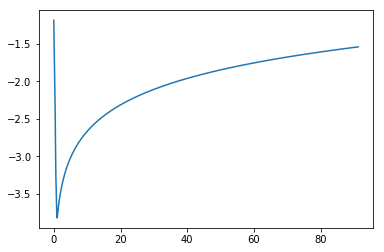

In [9]:
plt.plot(t_new, Ft_new)

In [16]:
mask=t_new>2
window = signal.hann(len(t_new[mask]))

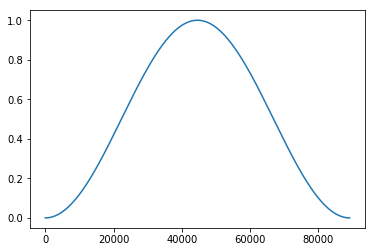

In [18]:
plt.plot(window)

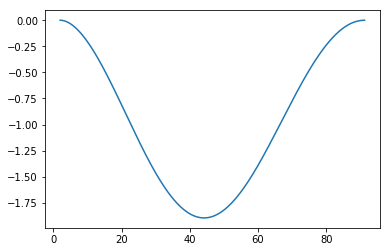

In [17]:
plt.plot(t_new[mask], Ft_new[mask]*window)


In [132]:
from pylab import *
mask=t_new>2
signal=Ft_new[mask]+randn(len(t_new[mask]))*0.01

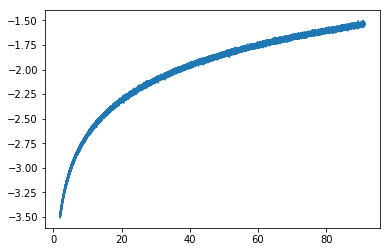

In [133]:
plt.plot(t_new[mask], signal)

In [174]:
#https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

#https://flothesof.github.io/FFT-window-properties-frequency-analysis.html

window_len=100
#s=np.r_[signal[window_len-1:0:-1],signal,signal[-2:-window_len-1:-1]]
print('signal',len(signal))
w=np.hanning(window_len)
print(len(w))

y=np.convolve(w/w.sum(),signal,mode='full')
y=y[int((window_len/2-1)):-int((window_len/2))]

signal 89240
100


In [175]:
len(y)

89240

In [165]:
len(y)

89438

In [170]:
len(signal)

89240

In [171]:
len(s)

89438

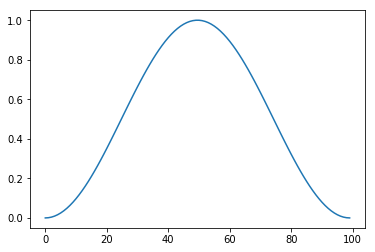

In [144]:
plt.plot(w)

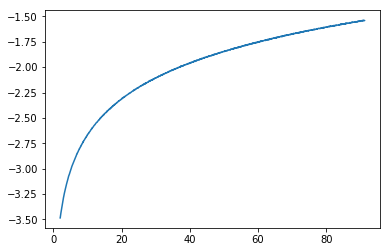

In [145]:
plt.plot(t_new[mask],y)